In [ ]:
import xarray as xr

In [2]:
import numpy as np
import xarray as xr
import os
from utils import modify_single_grib, truncate_grib_file
from cdo import Cdo
cdo = Cdo()
cdo.debug = True


def modify_value(field, var, newvalue):
    """
    Modify a field in the GRIB file setting it to a constant
    """
    for v in var:
        if v in field.variables:
            print(f"Modifying variable {v} in the field")
            field[v].data = np.full(field[v].shape, newvalue)
    return field

def replace_value(field, var, newfield):
    """
    Replace the field in a dataset with a dataarray
    """
    if 'time' not in newfield.dims:
        newfield = newfield.expand_dims('time', axis=0)

    for v in var:
        if v in field.variables:
            print(f"Replacing variable {v} in the field")
            field[v].data = newfield.data
    return field

indir='/lus/h2resw01/hpcperm/ccpd/ECE4-DATA/oifs/TL63L31/19900101'
climate_indir='/lus/h2resw01/hpcperm/ccpd/ECE4-DATA/oifs/TL63L31/climate.v020'
#outdir='/lus/h2resw01/scratch/ccpd/OIFS-playground'
outdir='/lus/h2resw01/hpcperm/ccpd/ECE4-DATA-test/oifs/TL63L31/19900101'
climate_outdir='/lus/h2resw01/hpcperm/ccpd/ECE4-DATA-test/oifs/TL63L31/climate.v020'
amip_outdir = '/lus/h2resw01/hpcperm/ccpd/ECE4-DATA-test/amip-forcing'
amip_indir = '/lus/h2resw01/hpcperm/ccpd/ECE4-DATA/amip-forcing'
herold_dir = '/perm/itas/db/deepMIP/Herold_etal_2014'

icefield = xr.open_dataset(os.path.join(amip_indir, 'siconcbcs_input4MIPs_SSTsAndSeaIce_CMIP_PCMDI-AMIP-1-1-3_gn_187001-201706.nc'))
icefield['siconcbcs'] = icefield['siconcbcs']*0.0
outfile = os.path.join(amip_outdir, 'siconcbcs_input4MIPs_SSTsAndSeaIce_CMIP_PCMDI-AMIP-1-1-3_gn_187001-201706.nc')
if os.path.exists(outfile):
    os.remove(outfile)
icefield.to_netcdf(outfile)


In [4]:
orog = xr.open_dataset(os.path.join(herold_dir, 'orography_remap.nc'))
landsea = xr.open_dataset(os.path.join(herold_dir, 'landsea_mask_remap.nc'))

In [ ]:
landsea['landsea_mask'].expand_dims('time', axis=0)

<xarray.DataArray 'landsea_mask' (time: 1, lat: 64, lon: 128)> Size: 66kB
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]]], shape=(1, 64, 128))
Coordinates:
  * lon      (lon) float64 1kB 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * lat      (lat) float64 512B 87.86 85.1 82.31 79.53 ... -82.31 -85.1 -87.86
Dimensions without coordinates: time
Attributes:
    CDI_grid_type:     gaussian
    CDI_grid_num_LPE:  32

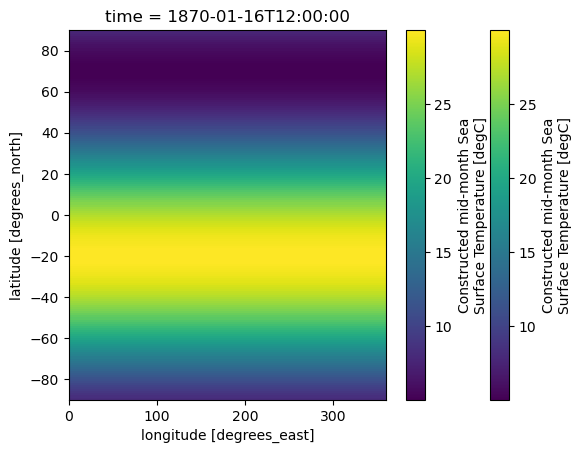

In [ ]:

def generate_seasonal_sst(inputfile, outputfile, A=25, OFFSET=20, T0=5):
    """
    Generate a seasonal SST latitudinal pattern and save it to a netCDF file.
    Parameters:
    - inputfile: Path to the input netCDF file.
    - outputfile: Path to the output netCDF file.
    - A: Amplitude of the latitudinal SST pattern.
    - OFFSET: Phase offset in degree for the seasonal pattern.
    - T0: Mean temperature.
    """

    sstfield = xr.open_dataset(inputfile)
    sstfield['tosbcs'].shape
    lons = sstfield['lon'].values
    lats = sstfield['lat'].values
    lon2d, lat2d = np.meshgrid(lons, lats)

    # Sinusoidal parameters
    A = 25        # Amplitude in degrees Celsius
    #B = 5      # Amplitude in degrees Celsius
    #beta = 45    # Phase shift in degrees
    k_lat = np.pi / 180    # frequency in lat direction
    #k_lon = np.pi / 180 * 4    # frequency in lon direction
    T0 = 5       # Mean temperature
    OFFSET = 20

    seasonal = np.cos(np.linspace(0,2*np.pi,num=13))[:-1]* OFFSET

    # Create sinusoidal SST pattern
    sst_pattern = []
    for phasing in seasonal:
        sst_pattern.append(A * np.pow(np.cos(k_lat * lat2d + np.pi/180* phasing), 2) + T0) #+ B * np.sin(k_lon * lon2d + np.pi/180*beta) + T0
    sst_stack = np.stack(sst_pattern, axis=0)
    stacksize = sstfield['tosbcs'].shape[0]
    sst_broadcast = np.tile(sst_stack, ((stacksize+11)//12, 1, 1))[:stacksize]
    sstfield['tosbcs'].data = sst_broadcast
    #sst_broadcast = np.broadcast_to(sst_stack, sstfield['tosbcs'].shape)
    #(sstfield['tosbcs'].isel(time=6)-sstfield['tosbcs'].isel(time=0)).plot()
    if os.path.exists(outputfile):
        os.remove(outputfile)
    sstfield.to_netcdf(outputfile)

generate_seasonal_sst(
    inputfile=os.path.join(amip_indir, 'tosbcs_input4MIPs_SSTsAndSeaIce_CMIP_PCMDI-AMIP-1-1-3_gn_187001-201706.nc'),
    outputfile=os.path.join(amip_outdir, 'tosbcs_input4MIPs_SSTsAndSeaIce_CMIP_PCMDI-AMIP-1-1-3_gn_187001-201706.nc')
)


In [9]:




# modify climate file
cdo.splitname(input=os.path.join(climate_indir,'ICMCLECE4'), 
              output=os.path.join(climate_outdir,'ICMCLECE4_temp_'), 
              options="--eccodes -f grb2")

match_dict = {
    "al": 0.15,
    "aluvp": 0.06,
    "aluvd": 0.06,
    "alnip": 0.06,
    "alnid": 0.06,
    "lai_lv": 0.,
    "lai_hv": 0.,
}

for var, new_value in match_dict.items():
    modify_single_grib(
        inputfile=os.path.join(climate_outdir, f'ICMCLECE4_temp_{var}.grb'),
        outputfile=os.path.join(climate_outdir, f'ICMCLECE4_mod_{var}.grb'),
        variables=[var],
        spectral=False,
        myfunction=modify_value,
        newvalue=new_value
    )
    os.remove(os.path.join(climate_outdir, f'ICMCLECE4_temp_{var}.grb'))

variables = list(match_dict.keys())
paths = [os.path.join(climate_outdir, f'ICMCLECE4_mod_{var}.grb') for var in variables]
if os.path.exists(os.path.join(climate_outdir, 'ICMCLECE4')):
    os.remove(os.path.join(climate_outdir, 'ICMCLECE4'))
cdo.mergetime(options="-L", input=paths, 
              output=os.path.join(climate_outdir, 'ICMCLECE4_almost'))
cdo.settaxis("9999-01-15,00:00:00,1month", input=os.path.join(climate_outdir, 'ICMCLECE4_almost'),
              output=os.path.join(climate_outdir, 'ICMCLECE4'), options="-a")
for path in paths:
    os.remove(path)


# DEBUG - start =============================================================
CALL  :cdo -O -s --eccodes -f grb2 -splitname /lus/h2resw01/hpcperm/ccpd/ECE4-DATA/oifs/TL63L31/climate.v020/ICMCLECE4 /lus/h2resw01/hpcperm/ccpd/ECE4-DATA-test/oifs/TL63L31/climate.v020/ICMCLECE4_temp_
STDOUT:
STDERR:
# DEBUG - end ===============================================================
RETURNCODE:0
Converting to netcdf file /lus/h2resw01/hpcperm/ccpd/ECE4-DATA-test/oifs/TL63L31/climate.v020/ICMCLECE4_temp_al.grb
Modifying GRIB file /lus/h2resw01/hpcperm/ccpd/ECE4-DATA-test/oifs/TL63L31/climate.v020/ICMCLECE4_temp_al.grb using function modify_value
Modifying variable al in the field
Converting back to GRIB file /lus/h2resw01/scratch/ccpd/cdoPyzt7nizb5
Converting to netcdf file /lus/h2resw01/hpcperm/ccpd/ECE4-DATA-test/oifs/TL63L31/climate.v020/ICMCLECE4_temp_aluvp.grb
Modifying GRIB file /lus/h2resw01/hpcperm/ccpd/ECE4-DATA-test/oifs/TL63L31/climate.v020/ICMCLECE4_temp_aluvp.grb using function modify

ValueError: replacement data must match the Variable's shape. replacement data has shape (64, 128); Variable has shape (1, 64, 128)

In [ ]:

# erase all orography
modify_single_grib(
    inputfile=os.path.join(indir,'ICMSHECE4INIT'),
    outputfile=os.path.join(outdir,'ICMSHECE4INIT'),
    variables='z',
    spectral=True,
    myfunction=replace_value,
    newfield=orog['orography']*9.81
    #myfunction=modify_value,
    #new_value=0. 
)

# truncate spectral variables to first harmonic (mean value)
truncate_grib_file(
    inputfile=os.path.join(outdir,'ICMSHECE4INIT'),
    variables=['t','d','vo','lnsp'],
    outputfile=os.path.join(outdir,'ICMSHECE4INIT'),
)

# erase all subgrid orography
modify_single_grib(
    inputfile=os.path.join(indir,'ICMGGECE4INIT'),
    outputfile=os.path.join(outdir,'ICMGGECE4INIT_temp'),
    variables=['sdor', 'anor', 'isor', 'slor', 'cl', 'chnk', 'tvh', 'tvl','cvh', 'cvl'],
    spectral=False,
    myfunction=modify_value,
    newvalue=0.  
)

# erase all subgrid orography
modify_single_grib(
    inputfile=os.path.join(outdir,'ICMGGECE4INIT_temp'),
    outputfile=os.path.join(outdir,'ICMGGECE4INIT_temp1'),
    variables=['slt'],
    spectral=False,
    myfunction=modify_value,
    newvalue=3 
)

modify_single_grib(
    inputfile=os.path.join(outdir,'ICMGGECE4INIT_temp1'),
    outputfile=os.path.join(outdir,'ICMGGECE4INIT'),
    variables=['lsm'],
    spectral=False,
    myfunction=replace_value,
    newfield=landsea['landsea_mask']
)

# set humidity to 0
# swlv1, swvl2, swvl3, swvl4 to be set 0
#
modify_single_grib(
    inputfile=os.path.join(indir,'ICMGGECE4INIUA'),
    outputfile=os.path.join(outdir,'ICMGGECE4INIUA'),
    variables='q',
    spectral=False,
    myfunction=modify_value,
    newvalue=0.  
)





Converting to netcdf file /lus/h2resw01/hpcperm/ccpd/ECE4-DATA/oifs/TL63L31/19900101/ICMSHECE4INIT
Modifying GRIB file /lus/h2resw01/hpcperm/ccpd/ECE4-DATA/oifs/TL63L31/19900101/ICMSHECE4INIT using function replace_value
Replacing variable z in the field
Converting back to GRIB file /lus/h2resw01/scratch/ccpd/cdoPy6rz569_r
t,d,vo,lnsp
Converting to netcdf file /lus/h2resw01/hpcperm/ccpd/ECE4-DATA/oifs/TL63L31/19900101/ICMGGECE4INIT
Modifying GRIB file /lus/h2resw01/hpcperm/ccpd/ECE4-DATA/oifs/TL63L31/19900101/ICMGGECE4INIT using function modify_value
Modifying variable sdor in the field
Modifying variable anor in the field
Modifying variable isor in the field
Modifying variable slor in the field
Modifying variable cl in the field
Modifying variable chnk in the field
Modifying variable tvh in the field
Modifying variable tvl in the field
Modifying variable cvh in the field
Modifying variable cvl in the field
Converting back to GRIB file /lus/h2resw01/scratch/ccpd/cdoPyxzfqwm_n
Convertin

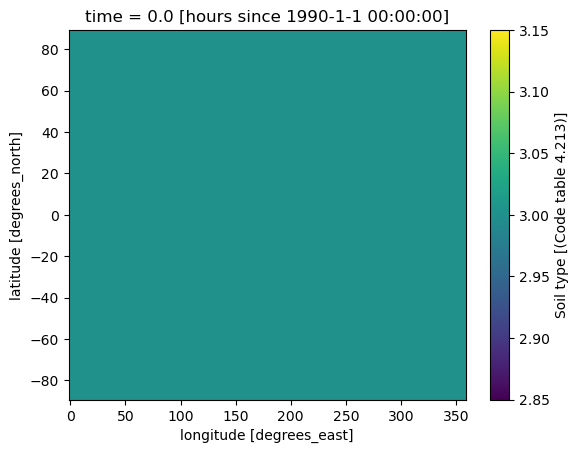

In [18]:
import xarray as xr
#cdo.setgridtype("regular", input=os.path.join(outdir, "ICMGGECE4INIT"), output=os.path.join(climate_outdir, "prova.nc"), options="-r -f nc --eccodes")
inputfile = os.path.join(climate_outdir, "prova.nc")
ds = xr.open_dataset(inputfile, decode_times=False, decode_cf=False, decode_timedelta=False)
ds['slt'].plot()
#ds.to_netcdf(os.path.join(climate_outdir, "new.nc"))
#cdo.remapnn(inputfile, input=os.path.join(climate_outdir, "new.nc"), output=os.path.join(climate_outdir, "new.grb"), options="-r -f grb2 --eccodes")

In [13]:
ds

<xarray.Dataset> Size: 3MB
Dimensions:       (time: 1, lon: 128, lat: 64, depth: 1, bnds: 2, depth_2: 1,
                   depth_3: 1, depth_4: 1, snow: 5)
Coordinates:
  * time          (time) float64 8B 0.0
  * lon           (lon) float64 1kB 0.0 2.812 5.625 8.438 ... 351.6 354.4 357.2
  * lat           (lat) float64 512B 87.86 85.1 82.31 ... -82.31 -85.1 -87.86
  * depth         (depth) float64 8B 0.0
  * depth_2       (depth_2) float64 8B 7.0
  * depth_3       (depth_3) float64 8B 28.0
  * depth_4       (depth_4) float64 8B 100.0
  * snow          (snow) float64 40B 0.0 1.0 2.0 3.0 4.0
Dimensions without coordinates: bnds
Data variables: (12/65)
    depth_bnds    (depth, bnds) float64 16B ...
    depth_2_bnds  (depth_2, bnds) float64 16B ...
    depth_3_bnds  (depth_3, bnds) float64 16B ...
    depth_4_bnds  (depth_4, bnds) float64 16B ...
    snow_bnds     (snow, bnds) float64 80B ...
    stl1          (time, depth, lat, lon) float32 33kB ...
    ...            ...
    cvh           (time, lat, lon) float32 33kB ...
    cvl           (time, lat, lon) float32 33kB ...
    tvh           (time, lat, lon) float32 33kB ...
    tvl           (time, lat, lon) float32 33kB ...
    cl            (time, lat, lon) float32 33kB ...
    slt           (time, lat, lon) float32 33kB ...
Attributes:
    CDI:          Climate Data Interface version 2.4.4 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      Tue Apr 15 15:46:39 2025: cdo -O -s -r -f nc --eccodes -set...
    CDO:          Climate Data Operators version 2.4.4 (https://mpimet.mpg.de...